In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics.regression import ContinuousRankedProbabilityScore
import shap

import seaborn as sns

## Load data

In [206]:
df21 = pd.read_csv("./filter_mu_atmo_surf_obs2345_promistK.csv")
DF25 = pd.read_csv("./mashup_2025.csv")

## temperature departure ch4_obs-sim sanity limits
maxTdep = 60.0   ## 5.0 for ch4; 6.0 for ist
minTdep = -20.550    ## -1.45 for ch4; -0.55 for ist

## Max distance between center_pixel and reference_AWS positions
max_distance_meters_pixelobs = 7
## Max difference between 2MT_nwp og 2MTDew_nwp. 0-15 K is range in data set 
max_difference_2mt_2mtdew = 15
## temperature sanity limits
maxt = 270.0 # -3°C 
mint = 200.0 # -73°C
## solar-zenith angle limits
maxsunzen = 180.0
minsunzen = 0.0
## Promice CAF upper limit
maxcaf = 1.2
## Maximum view angle
maxview = 75.0
## quality level range, ql greater than X
qlgrt = 0


## Filter data with multople conditions
df25 = DF25.loc[
    (DF25["lev1_sunzenith_angle"] >= minsunzen) & 
    (DF25["lev1_sunzenith_angle"] < maxsunzen) & 
    (DF25["lev1_satzenith_angle"] < maxview) & 
    (DF25["satcenter_station_dist_km"] < abs(max_distance_meters_pixelobs)) &     
    (DF25["lev2_quality_level"] > qlgrt) & 
    (DF25["lev2_surface_temperature"] > mint) & 
    (DF25["lev2_surface_temperature"] < maxt) & 
    (DF25["CloudCover"] < maxcaf) & 
    (DF25["nwp_t2m"]-DF25["nwp_d2m"] < max_difference_2mt_2mtdew) & 
    (DF25["SurfaceTemperature(C)"] > mint-273.15) & 
    (DF25["SurfaceTemperature(C)"] < maxt-273.15)]

df25 = df25.sort_values('lev1_obstime', ascending=True)

## Model features

In [207]:
# With channel5 - features taken from Zoe
input_features  = [
    # "MonthOfYear", "HourOfDay(UTC)",
    "lev1_channel4", "lev1_channel5", "lev1_sunzenith_angle", "lev1_satzenith_angle",# satellites input
    "nwp_t2m", "nwp_skt", "nwp_d2m", "nwp_tcc", "nwp_u10", "nwp_v10", "nwp_tcw", # example NWP vars
    
    # "nwp_t_1000_hPa", "nwp_t_950_hPa", "nwp_t_925_hPa",	"nwp_t_900_hPa", "nwp_t_850_hPa", "nwp_t_800_hPa", "nwp_t_700_hPa",
    # "nwp_t_600_hPa", "nwp_t_500_hPa", "nwp_t_400_hPa", "nwp_t_300_hPa", "nwp_t_250_hPa",
    # "nwp_t_200_hPa","nwp_t_150_hPa", "nwp_t_100_hPa", "nwp_t_70_hPa", "nwp_t_50_hPa", "nwp_t_30_hPa","nwp_t_20_hPa",
    # "nwp_t_10_hPa", "nwp_t_7_hPa", "nwp_t_5_hPa", "nwp_t_3_hPa", "nwp_t_2_hPa", "nwp_t_1_hPa",

    # "nwp_q_1000_hPa","nwp_q_950_hPa", "nwp_q_925_hPa",	"nwp_q_900_hPa", "nwp_q_850_hPa", "nwp_q_800_hPa", "nwp_q_700_hPa",
    # "nwp_q_600_hPa", "nwp_q_500_hPa", "nwp_q_400_hPa", "nwp_q_300_hPa", "nwp_q_250_hPa",
    # "nwp_q_200_hPa", "nwp_q_150_hPa", "nwp_q_100_hPa", "nwp_q_70_hPa", "nwp_q_50_hPa", "nwp_q_30_hPa",
    # "nwp_q_20_hPa","nwp_q_10_hPa",	"nwp_q_7_hPa", "nwp_q_5_hPa", "nwp_q_3_hPa", "nwp_q_2_hPa", "nwp_q_1_hPa",   
]

# No channel5 - remember to always check for duplicates
input_features2 = [
    "lev1_channel4", "lev1_sunzenith_angle", "lev1_satzenith_angle",
    "nwp_t2m", "nwp_skt", "nwp_d2m", "nwp_tcc", "nwp_u10", "nwp_v10", "nwp_tcw",
    "CloudCover", "nwp_t_1000_hPa", "nwp_q_1000_hPa", "WindSpeed(m/s)" # Features added to compensate for removal of channel5
]
# Correlation test
corr_features = ["lev1_channel4", "lev1_channel5", "lev1_sunzenith_angle","lev1_satzenith_angle", # OSISAF obs
           "nwp_t2m", "nwp_d2m", "nwp_tcc", "nwp_skt", "nwp_q2m", # nwp surf
           "rttov_channel4", "rttov_emis_channel4", # rttov
           "SurfaceTemperature(C)","AirTemperature(C)", "CloudCover", "ShortwaveRadiationDown(W/m2)", "Albedo_theta<70d", "SpecificHumidity(g/kg)", # promice
            "nwp_t_1000_hPa", "nwp_t_850_hPa", "nwp_t_300_hPa", "nwp_q_1000_hPa", "nwp_q_850_hPa", "nwp_q_300_hPa" # atmo
]

# target_column = "SurfaceTemperature(C)"
target_column = "promistK"


## Clean: drop rows with missing data
df_clean21 = df21[input_features + [target_column]].dropna()
df_clean21_2 = df21[input_features2 + [target_column]].dropna()
# df_clean21 = df21new[input_features + [target_column]].dropna()
df_clean25 = df25[input_features + [target_column]].dropna()
df_clean25_2 = df25[input_features2 + [target_column]].dropna()

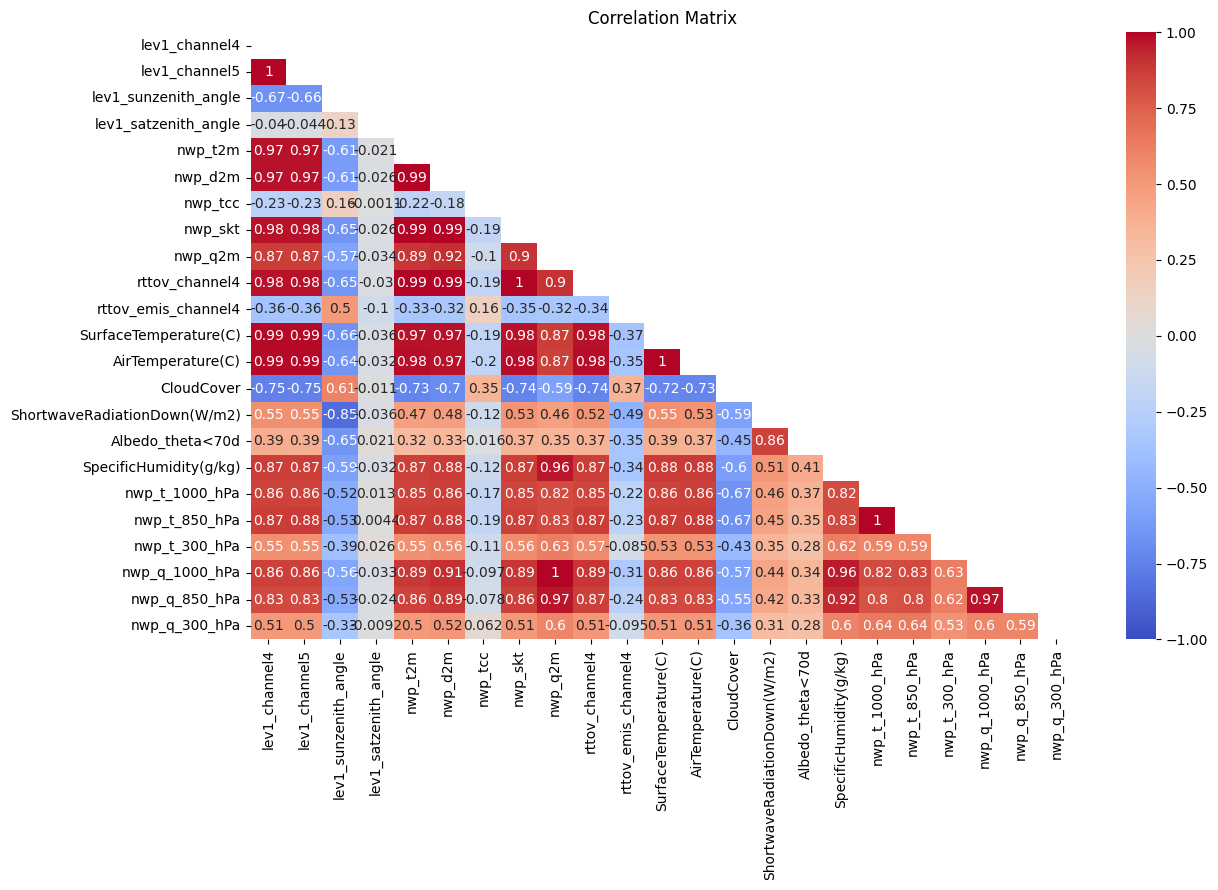

In [208]:
# Correlation matrix
corrM = df21[corr_features].corr()
# corrM.style.background_gradient(cmap='coolwarm').format(precision=2)

# ONLY ONE CORNER
mask = np.zeros_like(corrM, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corrM[mask] = np.nan

plt.figure(figsize=(13,9))
sns.heatmap(corrM, cmap="coolwarm",annot=True, vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [209]:
## Train/test split

X_train = df_clean21[input_features].values
X_test = df_clean25[input_features].values

X_train2 = df_clean21_2[input_features2].values
X_test2 = df_clean25_2[input_features2].values

y_train = df_clean21[target_column].values
y_test = df_clean25[target_column].values

y_train2 = df_clean21_2[target_column].values
y_test2 = df_clean25_2[target_column].values

## Datasets and Normalised Dataloader

In [210]:
class ISTDataset(Dataset):
    def __init__(self, X, y): # X: the input features and y: the labels (e.g.the ground truth IST)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self): # Returns the number of samples in your dataset. Required by PyTorch to know how many batches to expect.
        return len(self.X)

    def __getitem__(self, idx): #Returns a single sample (features & target) by index.PyTorch uses this to load data batch-by-batch during training.
        return self.X[idx], self.y[idx]

# Fit only on training data
train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0)

train_mean2 = X_train2.mean(axis=0)
train_std2 = X_train2.std(axis=0)

# Apply to both
X_train_scaled = (X_train - train_mean) / train_std
X_test_scaled = (X_test - train_mean) / train_std

X_train_scaled2 = (X_train2 - train_mean2) / train_std2
X_test_scaled2 = (X_test2 - train_mean2) / train_std2

# Create datasets
train_dataset = ISTDataset(X_train_scaled, y_train)
test_dataset = ISTDataset(X_test_scaled, y_test)

train_dataset2 = ISTDataset(X_train_scaled2, y_train2)
test_dataset2 = ISTDataset(X_test_scaled2, y_test2)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False)

print(X_train.shape)
print(X_train2.shape)

(3430, 11)
(3430, 14)


## Simple model

In [211]:
# MODEL: Define a simple neural network
class SimpleRegressor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)
    
model = SimpleRegressor(len(input_features))
model2 = SimpleRegressor(len(input_features2))

## Training

In [212]:
# Set up training tools
lr = 1e-3 # learning rate
loss_fn = nn.MSELoss() # mean squared error bc regression task
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # using Adam, a common and effective optimization algorithm
optimizer2 = torch.optim.Adam(model2.parameters(), lr=lr)

#  Train the model
epochs = 100
epoch_losses = [] # to stock the loss and track the learning of my model
epoch_losses2 = []
all_batch_losses = []
all_batch_losses2 = []

for epoch in range(epochs):
    model.train()
    model2.train()
    running_loss = 0.0
    running_loss2 = 0.0
    num_batches = 0
    num_batches2 = 0
    
    for X_batch, y_batch in train_loader:
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_batches += 1
        all_batch_losses.append(loss.item())  # Store each batch loss

    for X_batch, y_batch in train_loader2:
        preds = model2(X_batch)
        loss2 = loss_fn(preds, y_batch)
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()

        running_loss2 += loss2.item()
        num_batches2 += 1
        all_batch_losses2.append(loss2.item())

    avg_loss = running_loss / num_batches
    epoch_losses.append(avg_loss)

    avg_loss2 = running_loss2 / num_batches
    epoch_losses2.append(avg_loss2)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

Epoch 0 | Loss: 34813.9609
Epoch 10 | Loss: 129.7440
Epoch 20 | Loss: 36.1188
Epoch 30 | Loss: 3.4615
Epoch 40 | Loss: 1.6210
Epoch 50 | Loss: 3.6597
Epoch 60 | Loss: 0.8465
Epoch 70 | Loss: 1.8761
Epoch 80 | Loss: 1.7729
Epoch 90 | Loss: 9.7553


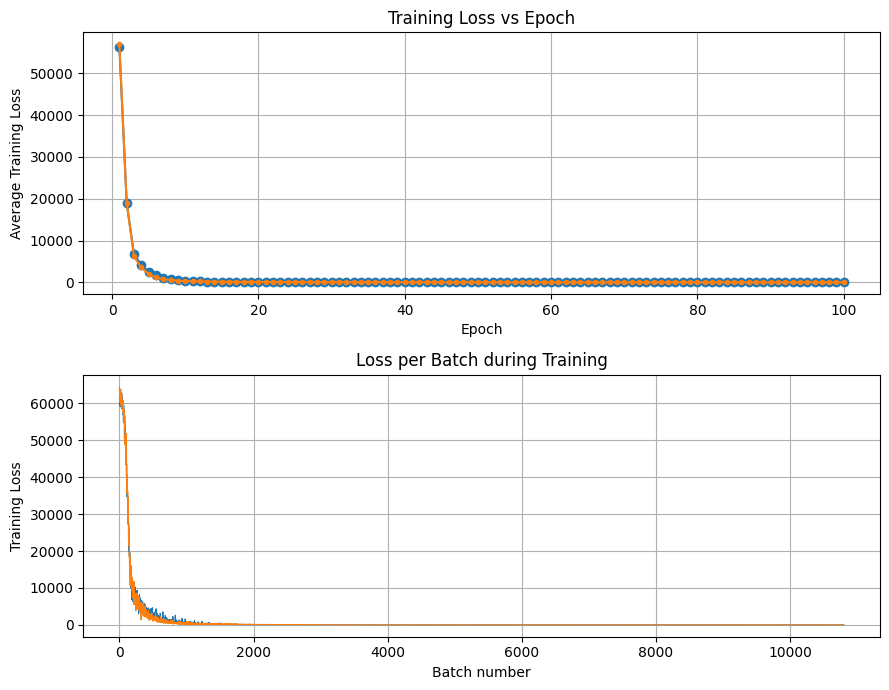

In [213]:
plt.figure(figsize=(9,7))

plt.subplot(2,1,1)
plt.plot(range(1, epochs+1), epoch_losses, marker='o')
plt.plot(range(1, epochs+1), epoch_losses2, marker=".")
plt.xlabel("Epoch")
plt.ylabel("Average Training Loss")
plt.title("Training Loss vs Epoch")
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(all_batch_losses, linewidth=0.7)
plt.plot(all_batch_losses2, linewidth=0.7)
plt.xlabel("Batch number")
plt.ylabel("Training Loss")
plt.title("Loss per Batch during Training")
plt.grid(True)

plt.tight_layout()
plt.show()

### Evaluation between the models

In [214]:
model.eval()
model2.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_pred = model(X_test_tensor).numpy()
    X_test_tensor2 = torch.tensor(X_test_scaled2, dtype=torch.float32)
    y_pred2 = model2(X_test_tensor2).numpy()

In [215]:
# y_test and y_pred to numpy arrays
y_test_np = np.array(y_test).flatten()
y_pred_np = np.array(y_pred).flatten()

y_test_np2 = np.array(y_test2).flatten()
y_pred_np2 = np.array(y_pred2).flatten()

# Compute
std_residuals = np.std(y_test_np - y_pred_np)
mean_residuals = np.mean(y_test_np - y_pred_np)

std_residuals2 = np.std(y_test_np2 - y_pred_np2)
mean_residuals2 = np.mean(y_test_np2 - y_pred_np2)

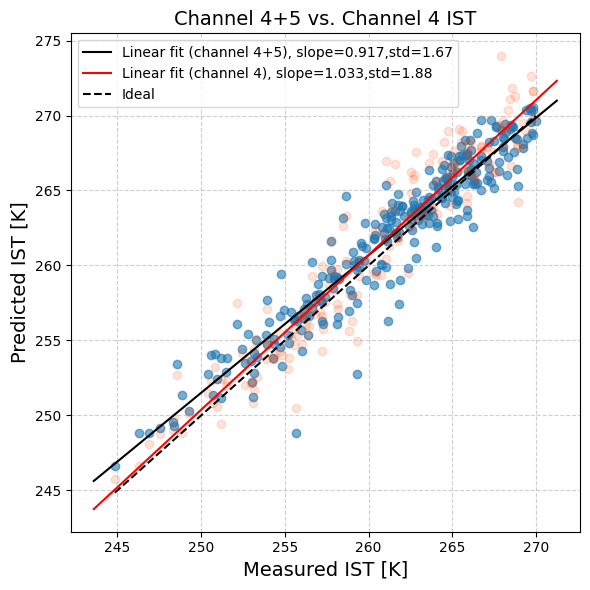

In [216]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_np, alpha=0.6)
plt.scatter(y_test2, y_pred_np2, alpha=0.15, color="orangered")

slope, intercept, r_value, p_value, std_err = linregress(y_test, y_pred_np)
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(y_test2, y_pred_np2)
x_vals = np.array(plt.xlim())  # take x axis limits
y_vals = intercept + slope * x_vals
y_vals2 = intercept2 + slope2 * x_vals
plt.plot(x_vals, y_vals, color="k", label=f"Linear fit (channel 4+5), slope={slope:.3f},std={std_residuals:.2f}")
plt.plot(x_vals, y_vals2, color="r", label=f"Linear fit (channel 4), slope={slope2:.3f},std={std_residuals2:.2f}")

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label="Ideal")
plt.title(f"Channel 4+5 vs. Channel 4 IST", fontsize = 14) 
plt.xlabel("Measured IST [K]", fontsize = 14)
plt.ylabel("Predicted IST [K]", fontsize = 14)
plt.legend(loc='upper left') #title="Fits",
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()